In [1]:
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst, wf_from_files, WfType
from invisible_cities.core.core_functions import in_range
from invisible_cities.database  import load_db
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_interactions import ioff, panhandler, zoom_factory
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from scipy.signal import find_peaks
from scipy.signal import wiener
from scipy.signal import butter, filtfilt
from pathlib  import Path

import sys
from datetime import datetime


In [2]:
def find_highest_wf(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]
    wfs[16] = np.arange(wfs[16] .size) * 0
    index = np.argmax(np.max(wfs, axis=1))
    print(index)
    return wfs[index]

def find_highest_sipm(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]
    index = np.argmax(np.max(wfs, axis=1))
    print(index)
    return index

In [3]:
def sum_wf1(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]

    element_wise_sum = np.zeros_like(wfs[0],dtype=np.int64)

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

def sum_wf(wfs):
    element_wise_sum = np.zeros_like(wfs[0])

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

def ADC_to_PE(wfs, datapmt):
    conv_factors = datapmt.adc_to_pes.to_numpy()

    for w in range(0, len(wfs)):
        wfs[w] = wfs[w]*conv_factors[w]

    return wfs

In [4]:
path = "../data/run_13852_0000_ldc1_trg0.waveforms.h5"

path = "../data/run_14180_0077_ldc7_trg0.waveforms.h5"

# path = "../data/xenon/run_14385_0000_ldc1_trg0.waveforms.h5"

raw_evts = pd.read_hdf(path, '/Run/events')
display(raw_evts)
print(raw_evts.evt_number.unique())

raw_evts = load_dst(path, 'Run', 'events')
nrwfs = len(raw_evts.evt_number.unique())
print("Number of Waveforms:", nrwfs)


,evt_number,timestamp
0,43637,1723015619631
1,43644,1723015619909
2,43651,1723015620208
3,43658,1723015620455
4,43665,1723015620753
...,...,...
76,44169,1723015648427
77,44176,1723015648766
78,44183,1723015649204
79,44190,1723015649630


[43637 43644 43651 43658 43665 43672 43679 43686 43693 43700 43707 43714
 43721 43728 43735 43742 43749 43756 43763 43770 43777 43784 43791 43798
 43805 43812 43819 43826 43833 43840 43847 43854 43861 43868 43875 43882
 43889 43896 43903 43910 43917 43924 43931 43938 43945 43952 43959 43966
 43973 43980 43987 43994 44001 44008 44015 44022 44029 44036 44043 44050
 44057 44064 44071 44078 44085 44092 44099 44106 44113 44120 44127 44134
 44141 44148 44155 44162 44169 44176 44183 44190 44197]
Number of Waveforms: 81


In [5]:
def find_fwhm(time, amplitude):
    max_amplitude = np.max(amplitude)
    half_max = max_amplitude / 2

    # Find indices where amplitude crosses half-maximum level
    above_half_max = np.where(amplitude >= half_max)[0]

    # First crossing point
    left_idx = above_half_max[0]
    right_idx = above_half_max[-1]

    # Interpolate to get more accurate crossing times
    t_left = np.interp(half_max, [amplitude[left_idx-1], amplitude[left_idx]], [time[left_idx-1], time[left_idx]])
    t_right = np.interp(half_max, [amplitude[right_idx], amplitude[right_idx+1]], [time[right_idx], time[right_idx+1]])

    fwhm = t_right - t_left
    return fwhm

In [6]:
# Load in the database for SiPMs
detector_db = "next100"
datasipm = load_db.DataSiPM(detector_db, 13852)
datapmt = load_db.DataPMT(detector_db, 13852)
display(datasipm)
display(datapmt)

,SensorID,ChannelID,Active,X,Y,adc_to_pes,Sigma
0,1000,36013,1,-482.625,-294.825,14.57,2.24
1,1001,36012,1,-482.625,-279.275,15.97,2.24
2,1002,36015,1,-482.625,-263.725,14.66,2.24
3,1003,36014,1,-482.625,-248.175,12.30,2.24
4,1004,36029,1,-482.625,-232.625,14.92,2.24
...,...,...,...,...,...,...,...
3579,56059,49054,1,490.025,245.425,14.25,2.24
3580,56060,49037,1,490.025,260.975,14.89,2.24
3581,56061,49036,1,490.025,276.525,15.10,2.24
3582,56062,49039,1,490.025,292.075,14.43,2.24


,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,100,PMTR11410,1,128.70000,6.400,0.000558,3.403945e-07,32.96,0,0.0
1,1,101,PMTR11410,1,66.20000,114.653,0.000564,2.844508e-07,33.89,0,0.0
2,2,102,PMTR11410,1,-58.80000,114.653,0.000564,2.597524e-07,42.89,0,0.0
3,3,103,PMTR11410,1,-121.30000,6.400,0.000561,3.982968e-07,40.00,0,0.0
4,4,104,PMTR11410,1,-58.80000,-101.853,0.000565,2.423053e-07,43.88,0,0.0
5,5,105,PMTR11410,1,66.20000,-101.853,0.000556,1.698570e-07,42.04,0,0.0
6,6,106,PMTR11410,1,253.70000,6.400,0.000555,3.161916e-07,52.51,0,0.0
7,7,107,PMTR11410,1,128.70000,222.906,0.000563,2.706561e-07,24.44,0,0.0
8,8,200,PMTR11410,1,-121.30000,222.906,0.000564,3.992381e-07,36.45,0,0.0
9,9,201,PMTR11410,1,-246.30000,6.400,0.000552,2.152614e-07,78.64,0,0.0


9
2476
212.125 -170.925


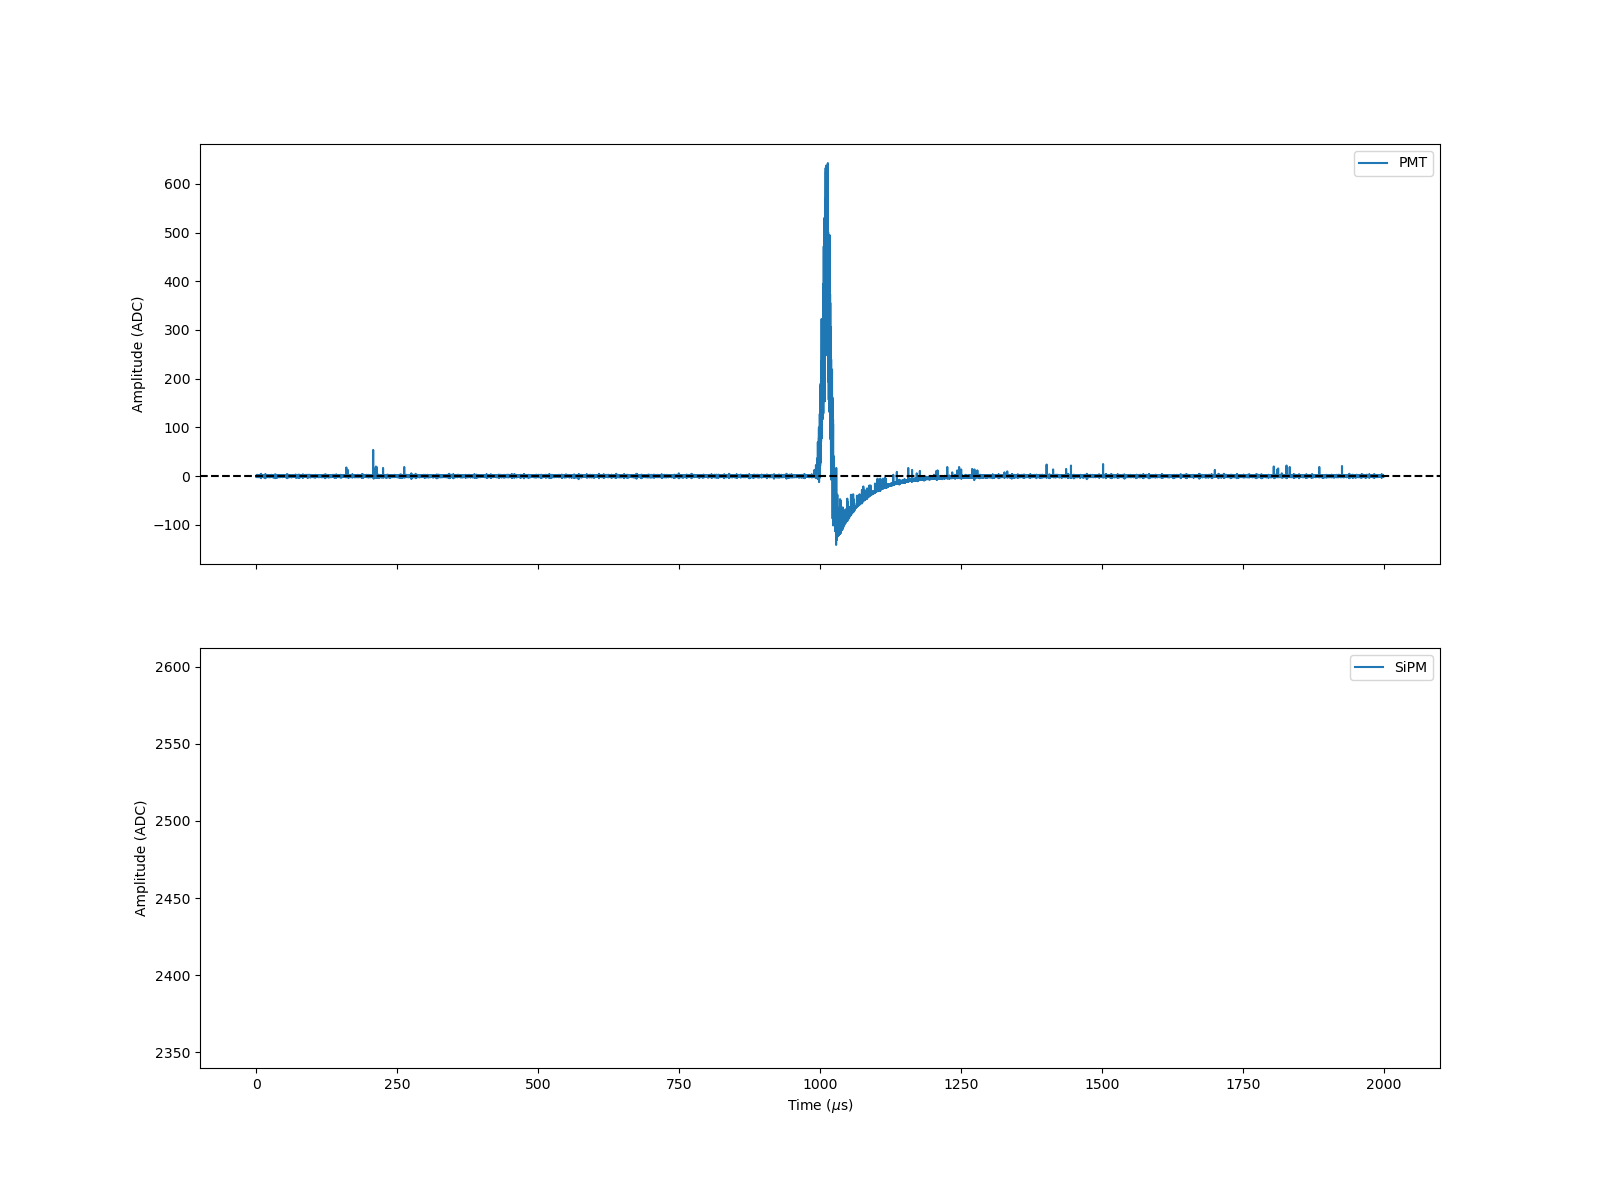

In [16]:
%matplotlib widget
# good events: 4,5,  37
event_number = 23

with tb.open_file(path) as file:
    wf_pmt  = find_highest_wf(file.root.RD. pmtrwf, event_number)
    # wf_blr  = find_highest_wf(file.root.RD. pmt_baselines, event_number)
    highest_sipm = find_highest_sipm(file.root.RD.sipmrwf, event_number)

    x_pos = datasipm.iloc[highest_sipm].X
    y_pos = datasipm.iloc[highest_sipm].Y
    print(x_pos, y_pos)

    # wf_blr_sum = [list(map(sum, zip(*rows))) for rows in zip(*file.root.RD.pmtblr[8])]

    sp_pmt  = 25e-3 # sampling period in mus
    sp_sipm = 1     # sampling period in mus
    t_pmt   = np.arange(wf_pmt .size) * sp_pmt
    t_sipm  = np.arange(highest_sipm.size) * sp_sipm

    baseline2=np.mean(wf_pmt[0:1000])
    # print(baseline2)


    wf_pmt = -1*(wf_pmt-baseline2)
    # t_pmt = t_pmt[36000:]
    # wf_pmt = wf_pmt[36000:]

    # wf_pmt = lowpass_filter(wf_pmt, 200, 1)


    _, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(16, 12))
    ax1.plot(t_pmt , wf_pmt , label = "PMT"); ax1.set_ylabel("Amplitude (ADC)")
    # ax2.plot(t_pmt , wf_blr , label = "PMT BLR"); ax2.set_ylabel("Amplitude (ADC)")
    ax3.plot(t_sipm, highest_sipm, label = "SiPM"); ax3.set_xlabel("Time ($\mu$s)");ax3.set_ylabel("Amplitude (ADC)")

    ax1.axhline(y=0, color='black', linestyle='--')

    ax1.legend(loc = "upper right")
    ax3.legend(loc = "upper right")


Error in baselines at start and end
-224.08300000001327
Error in baselines at start and end
-100.02800000002026
Error in baselines at start and end
-145.25199999997858
Error in baselines at start and end
-161.47299999999814
Error in baselines at start and end
123.50899999999092
Error in baselines at start and end
-141.24199999999837
Error in baselines at start and end
151.97099999999045
Error in baselines at start and end
-102.07400000002235
Error in baselines at start and end
-188.4440000000177
Error in baselines at start and end
109.75800000000163
Error in baselines at start and end
-139.02800000002026
Error in baselines at start and end
-176.03899999998976
Error in baselines at start and end
-186.1469999999972
Error in baselines at start and end
-102.35800000000745
Error in baselines at start and end
-200.6580000000249
Error in baselines at start and end
160.53100000001723
Error in baselines at start and end
141.85999999998603
Error in baselines at start and end
-192.7600000000093
E

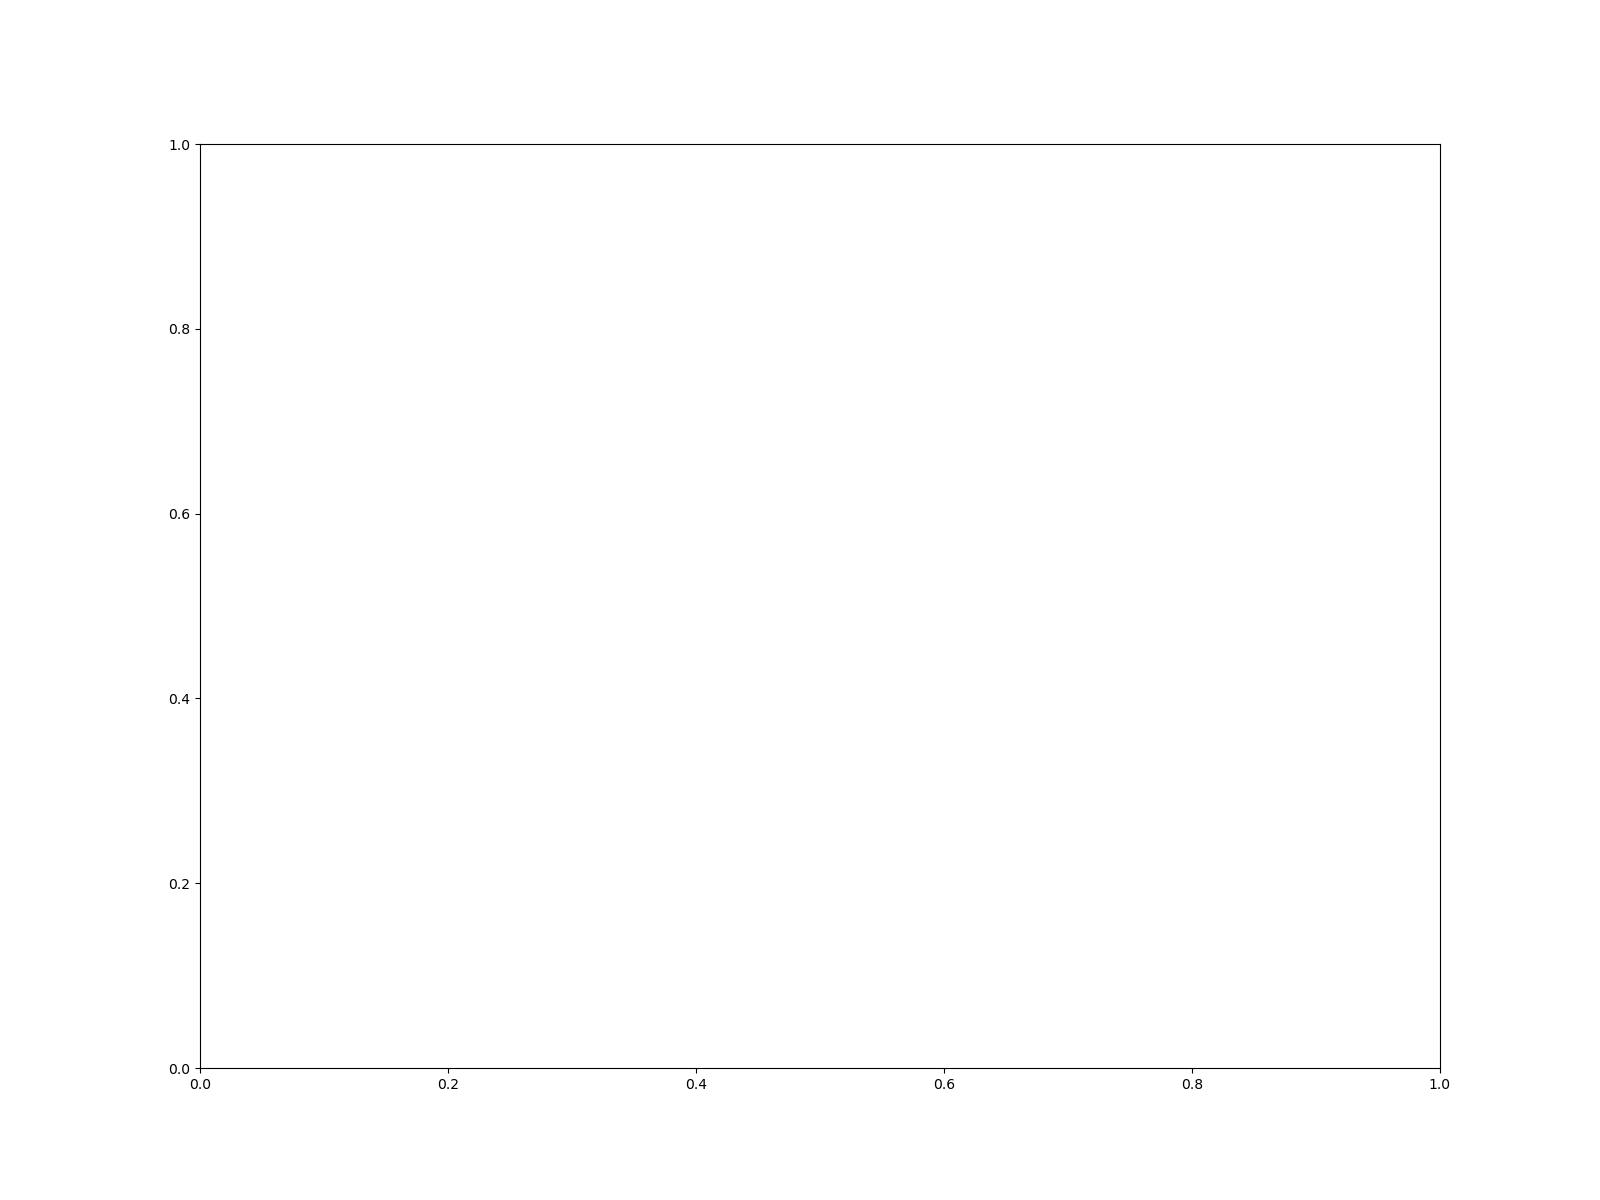

In [17]:
# good events: 4,5,  37
%matplotlib widget
event_number = 0
wf_sum=0

_, (ax1) = plt.subplots(1, 1, sharex=True, figsize=(16, 12))

for event_number in range(len(raw_evts.evt_number.unique())):
    with tb.open_file(path) as file:
        wf_pmt  = sum_wf1(file.root.RD. pmtrwf, event_number)
        wf_sipm = sum_wf1(file.root.RD.sipmrwf, event_number)

        # wf_blr_sum = [list(map(sum, zip(*rows))) for rows in zip(*file.root.RD.pmtblr[8])]

        # if (event_number != 19):
        #     continue

        sp_pmt  = 25e-3 # sampling period in mus
        sp_sipm = 1     # sampling period in mus
        t_pmt   = np.arange(wf_pmt .size) * sp_pmt
        t_sipm  = np.arange(wf_sipm.size) * sp_sipm

        baseline1=np.mean(wf_pmt[79000:80000])
        # print(baseline1)
        baseline2=np.mean(wf_pmt[0:1000])
        # print(baseline2)

        if (abs(baseline1-baseline2) > 100):
            print("Error in baselines at start and end")
            print(baseline1-baseline2)
            continue
        
        wf_pmt = -1*(wf_pmt-baseline2)
        t_pmt = t_pmt[36000:]
        wf_pmt = wf_pmt[36000:]

        peaks, _ = find_peaks(wf_pmt, height=300, distance=4000)

        if (len(peaks) > 1):
            continue

        if (len(peaks) < 1):
            continue

        if (event_number==0):
            wf_sum = wf_pmt
        else:
            wf_sum = wf_sum+wf_pmt

        
        ax1.plot(t_pmt - t_pmt[peaks][0] , wf_pmt, label = "PMT"); ax1.set_ylabel("Amplitude (ADC)")
        ax1.plot(t_pmt[peaks] - t_pmt[peaks][0], wf_pmt[peaks], 'x', label='Peaks')
        # ax3.plot(t_sipm, wf_sipm, label = "SiPM"); ax3.set_xlabel("Time ($\mu$s)");ax3.set_ylabel("Amplitude (ADC)")

        # ax1.legend(loc = "upper right")
        # ax3.legend(loc = "upper right")
        # plt.savefig(f"../plots/raw/run_13852_event{event_number}.png")

        # ax1.semilogy()
        ax1.set_xlabel("Time [mus]")
        ax1.axhline(y=0, color='black', linestyle='--')



# plt.figure()
# plt.plot(t_pmt - t_pmt[peaks][0] , wf_sum);
# plt.semilogy()


In [ ]:
def check_summed_baseline(wfs_sum, grass_lim, scale_factor):

    flag=False
    tc=25e-3
    
    # Check the baseline at the end and start match
    # otherwise there could be signal there so the baseline is all messed up
    baseline1=np.mean(wfs_sum[ int(1975/tc):int(2000/tc)])
    baseline2=np.mean(wfs_sum[0:int(25/tc)])

    # 20 seems like a good number to check the difference against
    if (abs(baseline1-baseline2) > 20*scale_factor):
        print("Error in baselines at start and end, dropping event")
        print(baseline1-baseline2)
        flag = True

    # Look in the window for large peaks that could be other S2 pulses. 
    # This will mess up the reconstruction
    peaks, _ = find_peaks(wfs_sum[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=8000, distance=40/tc)

    return flag, peaks

def get_PEs_inWindow(wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, grass_lim):

    df = []

    wfs = wfs[:, tsel]

    for pmt_no, wf in enumerate(wfs):

        idx_over_thr = np.argwhere(wf > noise[pmt_no]).flatten()
        splits       = np.argwhere(np.diff(idx_over_thr) > thr_split).flatten()
        idx_slices   = np.split(idx_over_thr, splits+1)
        idx_slices   = list(filter(lambda sl: in_range(len(sl), peak_minlen, peak_maxlen + .5), idx_slices))

        for sl in idx_slices:
            m = np.argmax(wf[sl]) + sl[0]
            pe_int = wf[m-half_window:m+half_window].sum()
            df.append(pd.DataFrame(dict(event = evt_info[evt_no][0], ts_raw=ts/1e3, pmt=pmt_no, pe_int=pe_int, peak_time=m*tc+grass_lim[0], noise_thr=noise[pmt_no]), index=[0]))

    return df


def CorrectRawBaseline(wfs):

    corrected_waveforms = []

    for wfm in wfs:
        baseline1=np.mean(wfm[ int(1975/tc):int(2000/tc)])
        baseline2=np.mean(wfm[0:int(25/tc)])
        wfm = -1*(wfm-baseline2)
        corrected_waveforms.append(wfm)

    return np.array(corrected_waveforms)



No such comm: fb0ded625c6f4e54a6559cd8c3881df1


No such comm: a8e385a1cd484e5bb711d03aa5cc895d


In [ ]:




filename  = "../data/run_13852_0000_ldc1_trg0.waveforms.h5"
# filename = "../data/run_14180_0085_ldc3_trg0.waveforms.h5"
folder_out = Path("../data/analysis/")
#folder_out = Path("/tmp/")

grass_lim   = 1350, 1770 # time window in mus in which to search for single pes
noise_lim   = 1900, 2000 # time window to calculate the noise baseline
thr_1pe     = 3.5 # threshold in adc to consider a peak a 1pe candidate
thr_split   = 2 # maximum number of samples allowed to be below threshold to consider it a peak
peak_minlen = 2  # minimum number of samples above threshold in a peak
peak_maxlen = 10 # maximum number of samples above threshold in a peak
half_window = 4 # number of samples to each side of a peak maximum to integrate
n_dark      = 10 # max number of samples without pe
tc          = 25e-3 # constant to convert from samples to time or vice versa. 
noise_sigma = 4 # how many STD above noise for the single PEs to be
scale_factor = 40*60 # Scale factor for summed waveform. 60 Pmts, 40 is ~ the conversion factor
cath_win     = 1770, 1830 # For run 13850
cath_win     = 1770, 1830 # For run 14180

useRaw = True


wf_sum = 0
wf_sum_clean = 0
wf_sum_14 = 0
wf_sum_15 = 0
wf_sum_16 = 0
wf_sum_17 = 0

deconv = deconv_pmt("next100", 13852, 62400)

data = []
data_properties = []
with tb.open_file(filename) as file:
    file_no=0
    evt_info = file.root.Run.events
    rwf      = file.root.RD.pmtrwf
    time     = np.arange(rwf.shape[2]) * tc
    tsel     = in_range(time, *grass_lim)
    for evt_no, wfs in enumerate(rwf):

        print("On Event:", evt_no)

        if (evt_no != 9):
            continue

        highest_sipm = find_highest_sipm(file.root.RD.sipmrwf, evt_no)
        x_pos = datasipm.iloc[highest_sipm].X
        y_pos = datasipm.iloc[highest_sipm].Y

        _, ts = evt_info[evt_no]
        
        if ( useRaw):
            wfs = CorrectRawBaseline(wfs)
        else:
            wfs = deconv(wfs)

        # Convert the ADC to PE
        wfs = ADC_to_PE(wfs, datapmt)

        wfs[16] = np.arange(wf_pmt[16] .size) * 0
        
        wfs_sum = sum_wf(wfs)

        times   = np.arange(wfs_sum .size) * 25e-3 # sampling period in mus

        # Check if  event failed the quality control
        pass_flag, grass_peaks = check_summed_baseline(wfs_sum, grass_lim, scale_factor)
        if (pass_flag):
            print("Skipping event...")
            continue

        S1, _ = find_peaks(wfs_sum[ int(100/tc):int(985/tc)], height=10000, distance=40/tc)
        S2, _ = find_peaks(wfs_sum[ int(985/tc):int(1200/tc)], height=200000, distance=200/tc)

        if (len(S1) !=1 or len(S2)!=1 ):
            deltaT = -999
        else:
            deltaT = S2[0]*tc+985 - (S1[0]*tc+100)
            # print("Time difference between S1 and S2:", deltaT)

        wf_sum_14+=wfs[36]
        wf_sum_15+=wfs[15]
        wf_sum_16+=wfs[16]
        wf_sum_17+=wfs[17]
        wf_sum_clean+=wfs_sum

        # Calcilate the noise of the PMT
        noise = []
        for pmt_no, wf in enumerate(wfs):
            noise.append(noise_sigma*np.std(wf[int(noise_lim[0]/tc):int(noise_lim[1]/tc)]))

        # Sum values in the peak up to the point where the pulse goes to zero
        S2_area = wfs_sum[int(990/tc):int(1030/tc)]
        S2_area = S2_area[S2_area > 0].sum()

        FWHM = find_fwhm(times[int(990/tc):int(1030/tc)], wfs_sum[int(990/tc):int(1030/tc)])
        print("Sigma is: ", FWHM/2.355)

        cath_df = get_PEs_inWindow(wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, [1780,1850])
        cath_df = pd.concat(cath_df, ignore_index=True)
        cath_area = cath_df.pe_int.sum()

        data_properties.append(pd.DataFrame(dict(event = evt_info[evt_no][0], S2_area=S2_area,cath_area=cath_area, ts_raw=ts/1e3, deltaT=deltaT, sigma = FWHM/2.355, x = x_pos, y = y_pos, grass_peaks = len(grass_peaks), nS1 = len(S1)), index=[0]))

        df = get_PEs_inWindow(wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, grass_lim)
        data = data + df

    data = pd.concat(data, ignore_index=True)
    data = data.assign(ts = np.array(list(map(datetime.fromtimestamp, data.ts_raw))))
    # data.to_hdf(file_out, "/data", complib="zlib", complevel=4, mode="w")

    data_properties = pd.concat(data_properties, ignore_index=True)
    data_properties = data_properties.assign(ts = np.array(list(map(datetime.fromtimestamp, data_properties.ts_raw))))



On Event: 0
On Event: 1
On Event: 2
On Event: 3
On Event: 4
On Event: 5
On Event: 6
On Event: 7
On Event: 8
On Event: 9
60
Sigma is:  4.670891643539854
On Event: 10
On Event: 11
On Event: 12
On Event: 13
On Event: 14
On Event: 15
On Event: 16
On Event: 17
On Event: 18
On Event: 19
On Event: 20
On Event: 21
On Event: 22
On Event: 23
On Event: 24
On Event: 25
On Event: 26
On Event: 27
On Event: 28
On Event: 29
On Event: 30
On Event: 31
On Event: 32
On Event: 33
On Event: 34
On Event: 35
On Event: 36
On Event: 37
On Event: 38
On Event: 39
On Event: 40
On Event: 41
On Event: 42
On Event: 43
On Event: 44
On Event: 45
On Event: 46
On Event: 47
On Event: 48
On Event: 49
On Event: 50
On Event: 51
On Event: 52
On Event: 53
On Event: 54
On Event: 55
On Event: 56
On Event: 57
On Event: 58
On Event: 59
On Event: 60
On Event: 61
On Event: 62
On Event: 63
On Event: 64
On Event: 65
On Event: 66
On Event: 67
On Event: 68
On Event: 69
On Event: 70
On Event: 71
On Event: 72
On Event: 73
On Event: 74
On 

In [ ]:
display(data)
display(data_properties)

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,65,1.717754e+09,0,1149.38112,1420.200,101.956825,2024-06-07 04:48:10.859
1,65,1.717754e+09,0,918.66112,1424.550,101.956825,2024-06-07 04:48:10.859
2,65,1.717754e+09,0,1643.78112,1487.175,101.956825,2024-06-07 04:48:10.859
3,65,1.717754e+09,0,1380.10112,1518.000,101.956825,2024-06-07 04:48:10.859
4,65,1.717754e+09,0,1478.98112,1519.075,101.956825,2024-06-07 04:48:10.859
...,...,...,...,...,...,...,...
407,65,1.717754e+09,59,1907.43120,1427.975,118.600112,2024-06-07 04:48:10.859
408,65,1.717754e+09,59,1429.89120,1443.525,118.600112,2024-06-07 04:48:10.859
409,65,1.717754e+09,59,815.91120,1476.250,118.600112,2024-06-07 04:48:10.859
410,65,1.717754e+09,59,1498.11120,1499.675,118.600112,2024-06-07 04:48:10.859


,event,S2_area,cath_area,ts_raw,deltaT,sigma,x,y,grass_peaks,nS1,ts
0,65,1.556381e+08,856308.56384,1.717754e+09,523.775,4.670892,-373.775,-232.625,0,1,2024-06-07 04:48:10.859


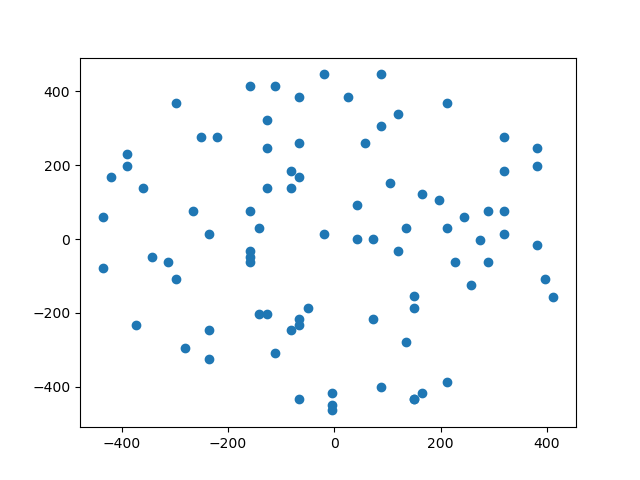

In [ ]:
plt.figure()

plt.scatter(data_properties.x, data_properties.y)

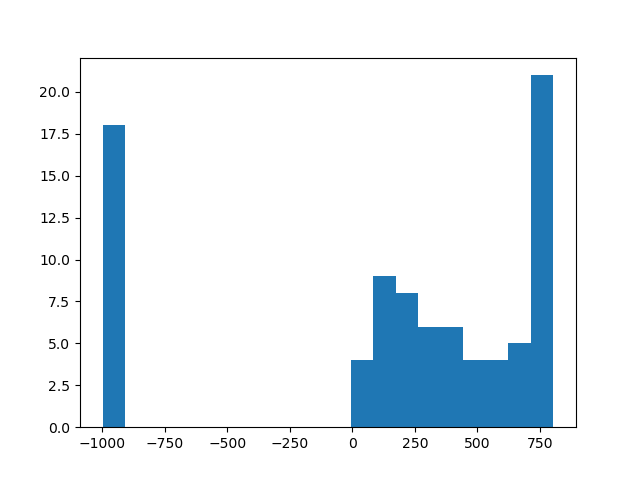

In [ ]:
plt.figure()
plt.hist(data_properties.deltaT, bins = 20);

Text(0, 0.5, 'Cathode PE Area [PE]')

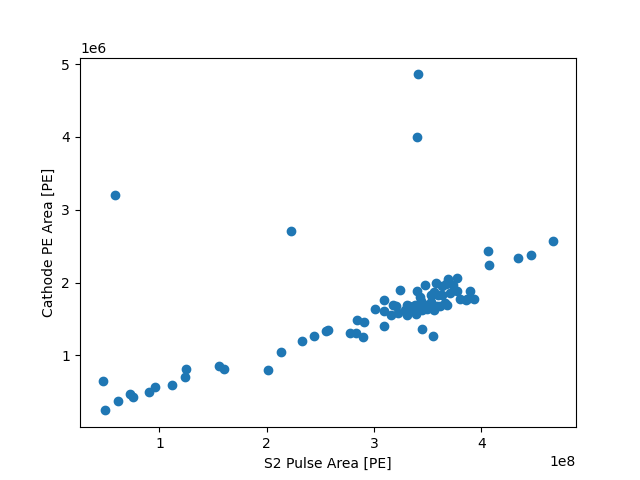

In [ ]:
plt.figure()
plt.scatter(data_properties.S2_area, data_properties.cath_area)
plt.xlabel("S2 Pulse Area [PE]")
plt.ylabel("Cathode PE Area [PE]")

[]
[484.15]


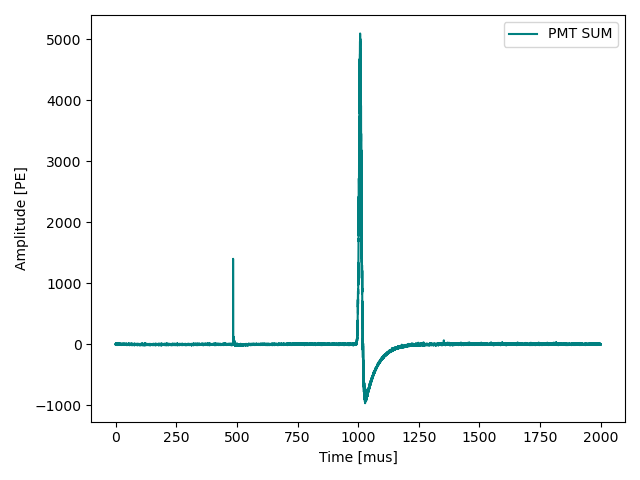

In [ ]:
plt.figure()
t_pmt   = np.arange(wf_sum_14 .size) * 25e-3 # sampling period in mus

# plt.plot(t_pmt , wf_sum_14, label = "PMT 14");
# plt.plot(t_pmt , wf_sum_15, label = "PMT 15", color = "Teal");
plt.plot(t_pmt , wf_sum_clean*1.3738395671424886e-08*1e6, label = "PMT SUM", color = "Teal");

peaks, _ = find_peaks(wf_sum_clean[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=8000, distance=40/tc)
print(peaks*tc+grass_lim[0])

peaks, _ = find_peaks(wf_sum_clean[ int(100/tc):int(985/tc)], height=10000, distance=40/tc)
print(peaks*tc+100)

# peaks, _ = find_peaks(wf_sum_15[ int(grass_lim[0]/25e-3):int(grass_lim[1]/25e-3)], height=noise[15], distance=1/25e-3)


# plt.plot(t_pmt , wf_sum_15, label = "PMT 42");
# plt.plot(t_pmt[peaks+int(grass_lim[0]/25e-3)], wf_sum_15[peaks+int(grass_lim[0]/25e-3)], 'x', label='Peaks')
# plt.plot(t_pmt , wf_sum_17, label = "PMT 17");

# plt.axhline(y=0, color='black', linestyle='--')

# plt.semilogy()
plt.xlabel("Time [mus]")
plt.ylabel("Amplitude [PE]")

# plt.xlim(1300, 1900)
# plt.ylim(-100, 1000)

plt.legend()
plt.tight_layout()

# plt.axvline(1350, linestyle = "--", color = "k", linewidth = 2)
# plt.axvline(1770, linestyle = "--", color = "k", linewidth = 2)
# plt.axvline(1780, linestyle = "--", color = "b", linewidth = 2)
# plt.axvline(1850, linestyle = "--", color = "b", linewidth = 2)

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,2,1.717754e+09,0,1109.03808,1350.625,124.111728,2024-06-07 04:48:07.489
1,2,1.717754e+09,0,1603.43808,1393.075,124.111728,2024-06-07 04:48:07.489
2,2,1.717754e+09,0,1603.43808,1400.175,124.111728,2024-06-07 04:48:07.489
3,2,1.717754e+09,0,1768.23808,1441.500,124.111728,2024-06-07 04:48:07.489
4,2,1.717754e+09,0,1603.43808,1461.150,124.111728,2024-06-07 04:48:07.489
...,...,...,...,...,...,...,...
68177,597,1.717754e+09,59,423.50976,1435.925,126.272327,2024-06-07 04:48:39.287
68178,597,1.717754e+09,59,1890.23976,1593.525,126.272327,2024-06-07 04:48:39.287
68179,597,1.717754e+09,59,1924.34976,1612.975,126.272327,2024-06-07 04:48:39.287
68180,597,1.717754e+09,59,1651.46976,1619.500,126.272327,2024-06-07 04:48:39.287


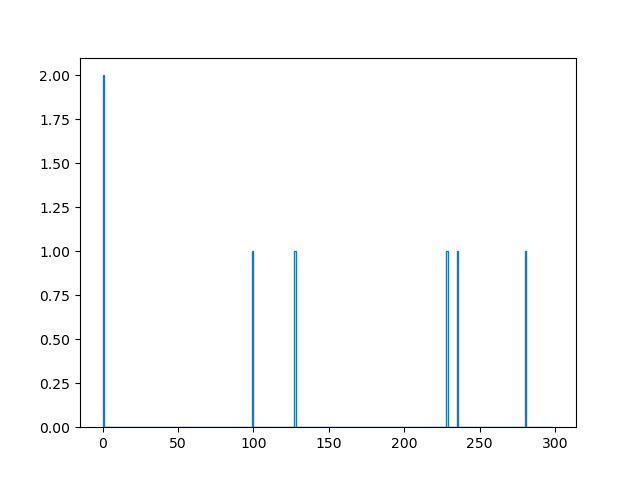

In [ ]:
display(data)
plt.figure()
# for pmt in data.pmt.unique():
    # if (pmt <= 50 and pmt >= 49):
    # plt.hist(data[data.pmt == pmt].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = pmt);


# plt.hist(data[data.pmt == 0].pe_int, bins = np.arange(0, 300, 1), histtype = "step",  label = "PMT 12");
plt.hist(data[data.pmt == 1].pe_int, bins = np.arange(0, 300, 1), histtype = "step",  label = "PMT 13");
# plt.hist(data[data.pmt == 2].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = "PMT 14");
# plt.hist(data[data.pmt == 3].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = "PMT 15");
# plt.hist(data[data.pmt == 4].pe_int, bins = np.arange(0, 300, 1), histtype = "step");
# plt.hist(data[data.pmt == 10].pe_int, bins = np.arange(0, 300, 2), histtype = "step");




# plt.legend()

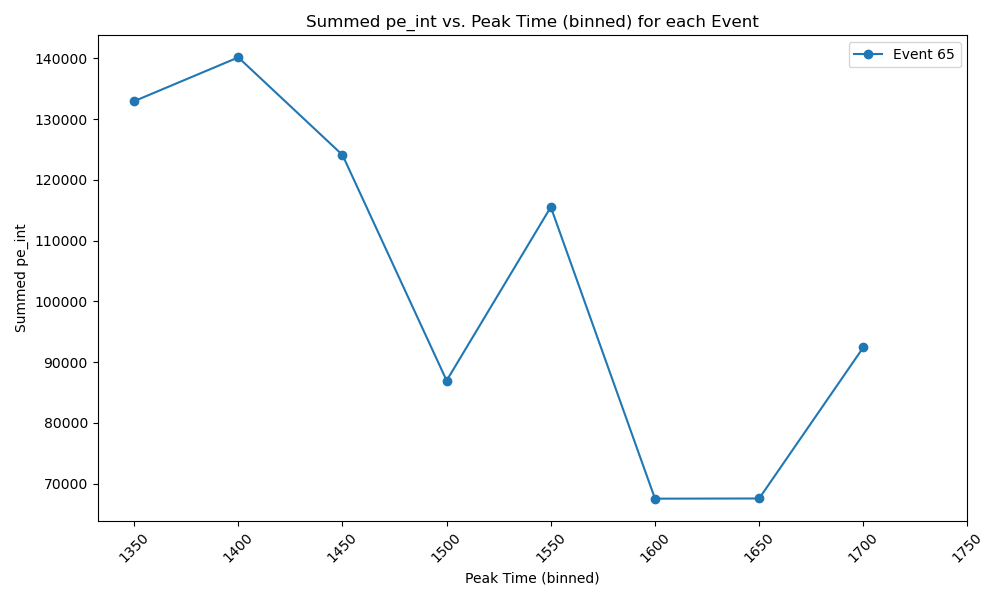

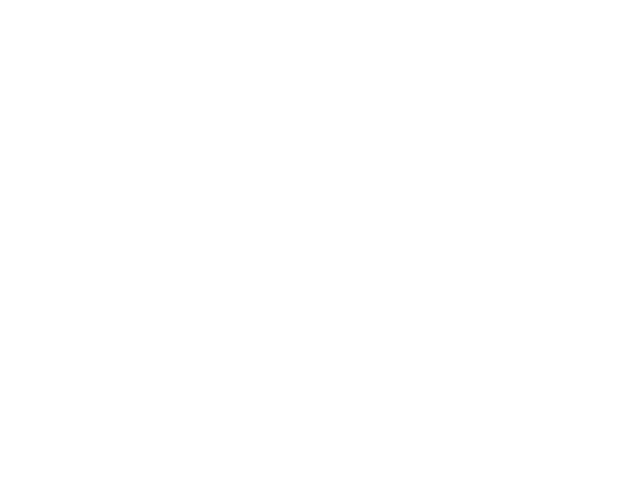

In [ ]:
# Plot the PE charge vs time in the window
plt.figure()

# 1. Group by 'event' and sum 'pe_int' for each event
# summed_pe_int = data.groupby('event')['pe_int'].sum()

# 1. Define bins for peak_time from 1350 to 1770 in steps of 10
bins = np.arange(1350, 1780, 50)  # Bins from 1350 to 1770 with step of 10
data['peak_time_bin'] = pd.cut(data['peak_time'], bins, include_lowest=True, labels=bins[:-1])

# 2. Group by 'event' and 'peak_time_bin', then sum 'pe_int'
grouped = data.groupby(['event', 'peak_time_bin'])['pe_int'].sum().reset_index()

# 3. Plot each event as a separate curve
plt.figure(figsize=(10, 6))

for event in grouped['event'].unique():
    event_data = grouped[grouped['event'] == event]
    S2_pulse = data_properties[data_properties['event'] == event]
    plt.plot(event_data['peak_time_bin'], event_data['pe_int'], marker='o', linestyle='-', label=f'Event {event}')
    # plt.plot(event_data['peak_time_bin'], event_data['pe_int']/S2_pulse.S2_area.item(), marker='o', linestyle='-', label=f'Event {event}')

# 4. Customize plot
plt.xlabel('Peak Time (binned)')
plt.ylabel('Summed pe_int')
plt.title('Summed pe_int vs. Peak Time (binned) for each Event')
plt.xticks(bins, rotation=45)
# plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



